In [1]:
import argparse
import datetime
import math
import os
import sys
import random
import pickle
import numpy as np
import pandas as pd
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
from omegaconf import OmegaConf
sys.path.append('/data2/youngju/kimst24')

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
from torchvision.utils import make_grid
import torchvision.transforms.functional as F
from torch.utils.data import DataLoader, Dataset, Subset, random_split
from torchvision import datasets, models, transforms
from tqdm.auto import tqdm
from utils.load_dataset import get_CUB_loaders
from utils.config_funcs import *
from utils.visualization import *

/home/youngju/anaconda3/envs/proto/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
parser = argparse.ArgumentParser()
parser.add_argument("--data-path", type=str, default="/data/CUB_200_2011/images")
parser.add_argument("--model-path", type=str, default="/data2/youngju/kimst24/outputs_backup/clf_checkpoints/2024-05-01_204226/clf_ep-24_lr-0.001_val-acc-0.7630.pth")
parser.add_argument("--pickle-path", type=str, default="/data2/youngju/kimst24/outputs/get_config/train")
parser.add_argument("--q_pickle-path", type=str, default="/data2/youngju/kimst24/outputs/get_config/test")
parser.add_argument("--q_th", type=int, default=200)
parser.add_argument("--seed", type=int, default=0)
parser.add_argument("--batch-size", type=int, default=512)
parser.add_argument("--num-pickle", type=int, default=7)
parser.add_argument("--device", type=str, default="cuda:5")
parser.add_argument("--train-ratio", type=float, default=0.7)

args = parser.parse_args(args=[])

In [3]:
MEAN = np.array([0.485, 0.456, 0.406])
STD = np.array([0.229, 0.224, 0.225])
unorm = UnNormalize(mean=MEAN, std=STD)

random.seed(args.seed)
torch.manual_seed(args.seed)
cudnn.deterministic = True
cudnn.benchmark = False

# (train_loader, train_data_len) = get_CUB_loaders(args.data_path, args.batch_size, args.train_ratio, train=True)
# (val_loader, test_loader, valid_data_len, test_data_len) = get_CUB_loaders(args.data_path, int(args.batch_size/2), args.train_ratio, train=False)

In [4]:
model = models.resnet50(pretrained=False)
model.fc = nn.Linear(2048, 200)
model.load_state_dict(torch.load(args.model_path))
model = model.to(args.device)
model.eval()

/home/youngju/anaconda3/envs/proto/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/youngju/anaconda3/envs/proto/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [5]:
with open(f"{args.pickle_path}/total_activation.pkl","rb") as fr:
    ac_total = torch.sign(pickle.load(fr))
with open(f"{args.pickle_path}/total_activation.pkl","rb") as fr:
    h_total = pickle.load(fr)
with open(f"{args.pickle_path}/total_eq.pkl","rb") as fr:
    eq_total = pickle.load(fr)
with open(f"{args.pickle_path}/total_x.pkl","rb") as fr:
    x_total = pickle.load(fr)
with open(f"{args.pickle_path}/total_y.pkl","rb") as fr:
    y_total = pickle.load(fr)
with open(f"{args.pickle_path}/total_preds.pkl","rb") as fr:
    preds_total = pickle.load(fr).cpu().detach()
with open(f"{args.pickle_path}/total_probs.pkl","rb") as fr:
    probs_total = pickle.load(fr).cpu().detach()

In [6]:
ac_total.shape, eq_total.shape, x_total.shape, y_total.shape

(torch.Size([8251, 2048, 7, 7]),
 torch.Size([8251]),
 torch.Size([8251, 3, 224, 224]),
 torch.Size([8251]))

In [7]:
with open(f"{args.q_pickle_path}/total_activation.pkl","rb") as fr:
    q_ac_total = torch.sign(pickle.load(fr))
with open(f"{args.q_pickle_path}/total_activation.pkl","rb") as fr:
    q_h_total = pickle.load(fr)
with open(f"{args.q_pickle_path}/total_eq.pkl","rb") as fr:
    q_eq_total = pickle.load(fr)
with open(f"{args.q_pickle_path}/total_x.pkl","rb") as fr:
    q_x_total = pickle.load(fr)
with open(f"{args.q_pickle_path}/total_y.pkl","rb") as fr:
    q_y_total = pickle.load(fr)
with open(f"{args.q_pickle_path}/total_preds.pkl","rb") as fr:
    q_preds_total = pickle.load(fr).cpu().detach()
with open(f"{args.q_pickle_path}/total_probs.pkl","rb") as fr:
    q_probs_total = pickle.load(fr).cpu().detach()

In [8]:
q_ac_total.shape, q_eq_total.shape, q_x_total.shape, q_y_total.shape

(torch.Size([1769, 2048, 7, 7]),
 torch.Size([1769]),
 torch.Size([1769, 3, 224, 224]),
 torch.Size([1769]))

In [9]:
with open(f"{args.q_pickle_path}/q_euc_density_{args.q_th}.pkl","rb") as fr:
    q_density = pickle.load(fr)
with open(f"{args.q_pickle_path}/q_euc_n_nearest_y_{args.q_th}.pkl","rb") as fr:
    q_n_nearest_y = pickle.load(fr)

# Density 분포 확인

(array([ 25.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   2.,   1.,   2.,
          5.,   4.,   1.,   2.,   2.,   3.,   1.,   1.,   3.,   3.,   0.,
          1.,   0.,   0.,   0.,   3.,   2.,   4.,   4.,   1.,   3.,   2.,
          3.,   3.,   4.,   4.,   1.,   3.,   5.,   8.,   3.,   4.,   9.,
         10.,   6.,   4.,   6.,   9.,   9.,  12.,   8.,   9.,  18.,  17.,
         19.,  15.,  26.,  24.,  27.,  26.,  40.,  39.,  53.,  59.,  60.,
         71.,  71.,  69.,  94.,  79.,  91.,  87., 105.,  94., 109.,  91.,
        189.]),
 array([     0.  ,   1003.52,   2007.04,   3010.56,   4014.08,   5017.6 ,
          6021.12,   7024.64,   8028.16,   9031.68,  10035.2 ,  11038.72,
         12042.24,  13045.76,  14049.28,  15052.8 ,  16056.32,  17059.84,
         18063.36,  19066.88,  20070.4 ,  21073.92,  22077.44,  23080.96,
         24084.48,  25

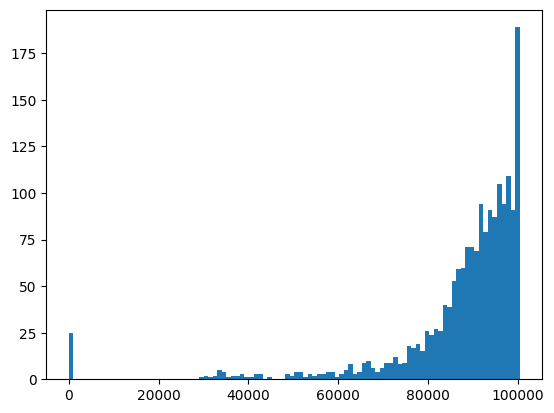

In [10]:
plt.hist(q_density, bins=100)

{'whiskers': [<matplotlib.lines.Line2D at 0x7fe9ac2cc8e0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fe9ac2cce20>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fe9ac2cc640>],
 'medians': [<matplotlib.lines.Line2D at 0x7fe9ac2df3a0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fe9ac2df640>],
 'means': []}

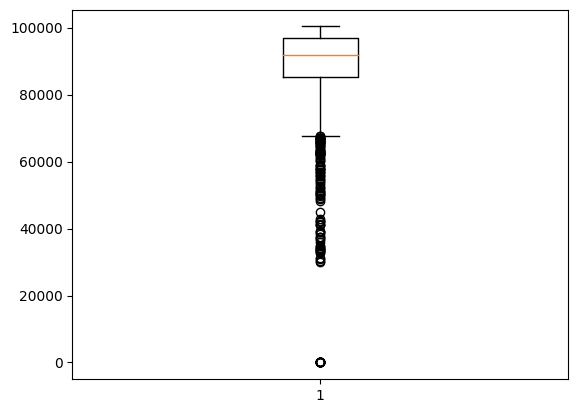

In [11]:
plt.boxplot(q_density)

Text(0.5, 0, 'Density of the regions')

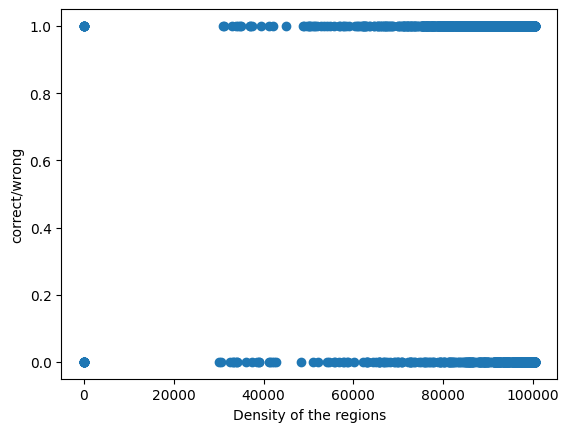

In [12]:
# density - eq
plt.scatter(q_density, q_eq_total.tolist())
plt.ylabel('correct/wrong')
plt.xlabel('Density of the regions')

In [13]:
import scipy.stats as stats
stats.spearmanr(q_density,q_eq_total.tolist())

SignificanceResult(statistic=-0.08545663444729078, pvalue=0.0003202978846311514)

Text(0.5, 0, 'Density of the regions')

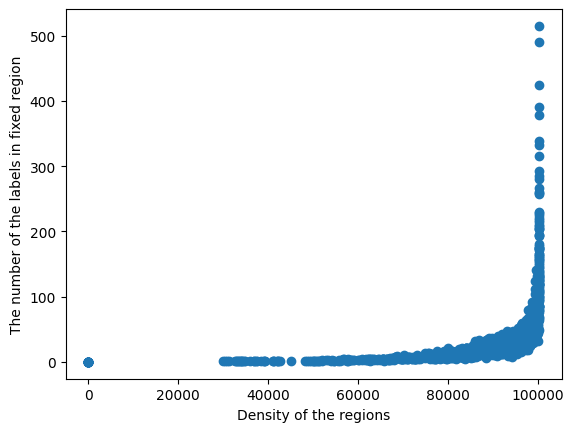

In [14]:
# density - the number of nearest y (label noise)
plt.scatter(q_density, q_n_nearest_y)
plt.ylabel('The number of the labels in fixed region')
plt.xlabel('Density of the regions')

Text(0.5, 0, 'Density of the regions')

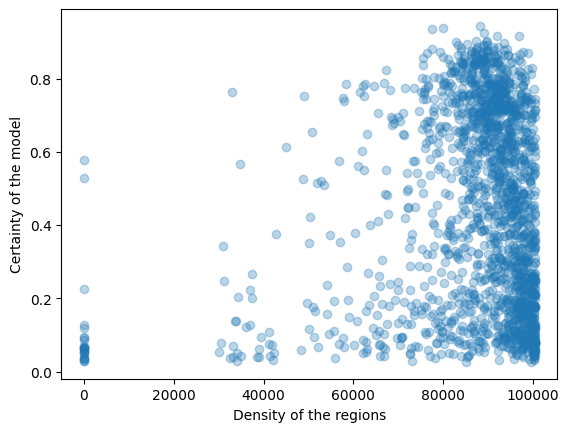

In [15]:
# density - the number of nearest y (label noise)
plt.scatter(q_density, q_probs_total.cpu().detach(), alpha=0.3)
plt.ylabel('Certainty of the model')
plt.xlabel('Density of the regions')

In [16]:
import scipy.stats as stats
stats.spearmanr(q_density,q_probs_total.cpu().detach().tolist())

SignificanceResult(statistic=-0.13127610753601512, pvalue=2.998928297848414e-08)

In [17]:
for i in range(0,100000,20000):
    q_idx_range = np.where((i<=np.array(q_density)) & (np.array(q_density)<(i+20000)))[0]
    acc = np.sum(np.array(q_eq_total)[q_idx_range])/len(q_idx_range)
    print(f'{i}~{i+20000}:        {acc}')
    print(f'개수:                  {len(q_idx_range)}')

0~20000:        0.32
개수:                  25
20000~40000:        0.4583333333333333
개수:                  24
40000~60000:        0.5853658536585366
개수:                  41
60000~80000:        0.734375
개수:                  192
80000~100000:        0.7929773226042429
개수:                  1367


Text(0, 0.5, 'Accuracy')

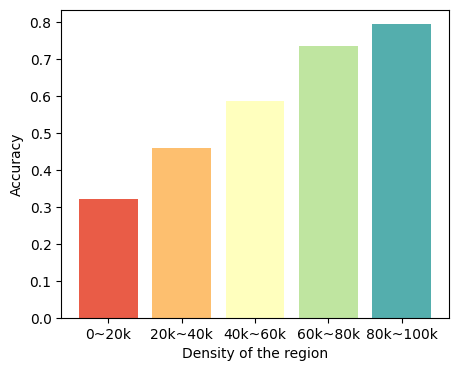

In [18]:
idx = np.arange(1, 6)
colors = sns.color_palette('Spectral',len(idx))
plt.figure(figsize = (5, 4))
labels = ['0~20k', '20k~40k', '40k~60k', '60k~80k', '80k~100k']
for j, i in enumerate(range(0,100000,20000)):
    q_idx_range = np.where((i<=np.array(q_density)) & (np.array(q_density)<(i+20000)))[0]
    acc = np.sum(np.array(q_eq_total)[q_idx_range])/len(q_idx_range)
    plt.bar(j+1, acc, color=colors[j])
plt.xticks(idx,labels)
plt.xlabel('Density of the query-region')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Ratio of the misclassified samples')

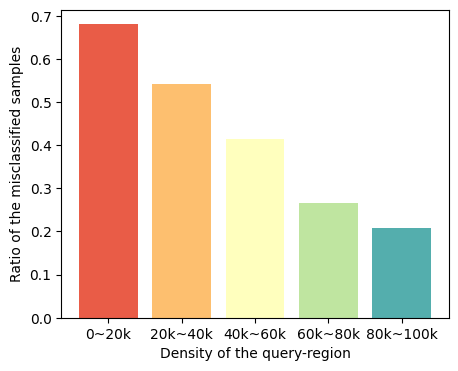

In [52]:
idx = np.arange(1, 6)
colors = sns.color_palette('Spectral',len(idx))
plt.figure(figsize = (5, 4))
labels = ['0~20k', '20k~40k', '40k~60k', '60k~80k', '80k~100k']
for j, i in enumerate(range(0,100000,20000)):
    q_idx_range = np.where((i<=np.array(q_density)) & (np.array(q_density)<(i+20000)))[0]
    acc = np.sum(np.array(1-q_eq_total)[q_idx_range])/len(q_idx_range)
    plt.bar(j+1, acc, color=colors[j])
plt.xticks(idx,labels)
plt.xlabel('Density of the query-region')
plt.ylabel('Ratio of the misclassified samples')

In [20]:
for i in range(0,100000,20000):
    q_idx_range = np.where((i<=np.array(q_density)) & (np.array(q_density)<(i+20000)))[0]
    #acc = np.sum(np.array(q_probs_total.cpu().detach())[q_idx_range])/len(q_idx_range)
    prob = np.mean(np.array(q_probs_total.cpu().detach())[q_idx_range])
    print(f'{i}~{i+20000}:        {prob}')
    print(f'개수:                  {len(q_idx_range)}')

0~20000:        0.10839145630598068
개수:                  25
20000~40000:        0.16536200046539307
개수:                  24
40000~60000:        0.28697168827056885
개수:                  41
60000~80000:        0.40573158860206604
개수:                  192
80000~100000:        0.4838055372238159
개수:                  1367


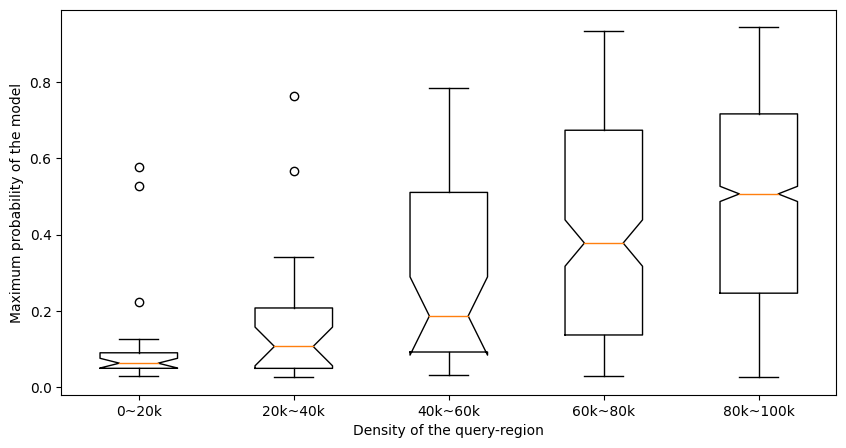

In [51]:
idx = np.arange(1, 6)
plt.figure(figsize = (10, 5))
labels = ['0~20k', '20k~40k', '40k~60k', '60k~80k', '80k~100k']
plt.boxplot([np.array(q_probs_total.cpu().detach())[np.where((0<=np.array(q_density)) & (np.array(q_density)<(20000)))[0]],
            np.array(q_probs_total.cpu().detach())[np.where((20000<=np.array(q_density)) & (np.array(q_density)<(40000)))[0]],
            np.array(q_probs_total.cpu().detach())[np.where((40000<=np.array(q_density)) & (np.array(q_density)<(60000)))[0]], 
            np.array(q_probs_total.cpu().detach())[np.where((60000<=np.array(q_density)) & (np.array(q_density)<(80000)))[0]],
            np.array(q_probs_total.cpu().detach())[np.where((80000<=np.array(q_density)) & (np.array(q_density)<(100000)))[0]]
            ], notch = True)
plt.xticks(idx,labels)
plt.xlabel('Density of the query-region')
plt.ylabel('Maximum probability of the model')
plt.show()

# Low density region vs High density region

## Overall

In [171]:
num_zero = (np.array(q_density) == 0).sum()
num_zero

25

In [22]:
k = 32
low_density_idx = np.argsort(q_density)[:k].tolist()
high_density_idx = np.argsort(q_density)[-k:].tolist()

In [173]:
unorm = UnNormalize(mean=MEAN, std=STD)
low_den_samples = []
high_den_samples = []
for q_low_idx in low_density_idx:
    low_den_samples.append(unorm(q_x_total[q_low_idx]))
for q_high_idx in high_density_idx:
    high_den_samples.append(unorm(q_x_total[q_high_idx]))

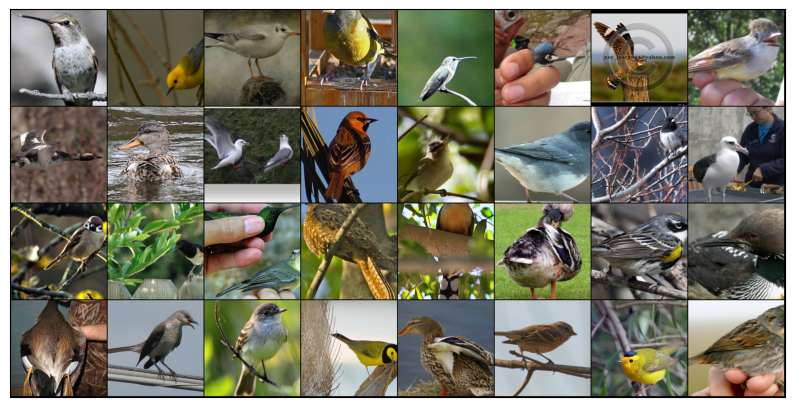

In [174]:
low_den_grid = make_grid(low_den_samples)
show(low_den_grid)

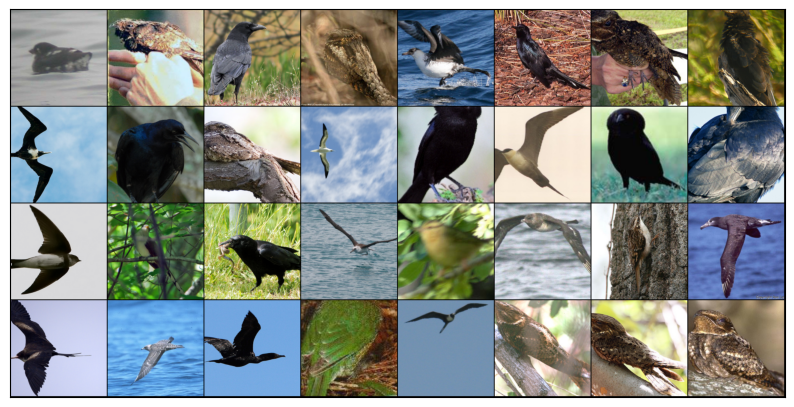

In [175]:
high_den_grid = make_grid(high_den_samples)
show(high_den_grid)

## 같은 label을 갖지만 region의 density 정도가 다른 경우 비교

In [193]:
low_density_idx[:10]

[393, 810, 1439, 1591, 507, 1372, 492, 795, 1319, 1052]

(array([12., 11.,  7., 11.,  6.,  5.,  7., 11.,  7.,  9.,  6., 10., 10.,
        13.,  7., 10.,  2.,  6., 10.,  7., 12.,  9.,  7.,  7.,  7.,  7.,
         7., 10., 10.,  7.,  8.,  9., 12.,  7.,  9.,  6., 15.,  8.,  7.,
         9.,  9., 10., 10., 13.,  8.,  8.,  7.,  9., 12.,  7.,  4.,  9.,
         7.,  7., 10.,  6., 10.,  6., 12.,  9.,  9., 10.,  9.,  8.,  6.,
        14., 10.,  7., 10., 11.,  9.,  8.,  8.,  7., 16., 20., 12., 11.,
         8.,  9.,  7.,  5.,  6., 13., 10.,  8., 12., 15., 14.,  6., 11.,
        10.,  6.,  9.,  9., 11., 10., 12., 10., 10., 11.,  6.,  8.,  7.,
        13.,  7.,  9., 12.,  4.,  8.,  6.,  8.,  9.,  6.,  7., 19.,  8.,
         5.,  6., 10.,  7.,  8.,  9., 11., 10.,  6.,  4.,  8., 10., 10.,
        11.,  8.,  8.,  9., 12., 10., 12.,  8.,  7.,  6., 11., 10., 14.,
         5.,  8.,  7., 10.,  7.,  7., 10.,  6.,  6., 14., 11.,  6.,  7.,
         8.,  9.,  8., 10., 16.,  9., 11.,  9., 12.,  3., 10.,  8., 10.,
         8., 11.,  7.,  5.,  6., 11.,  9.,  8.,  5.

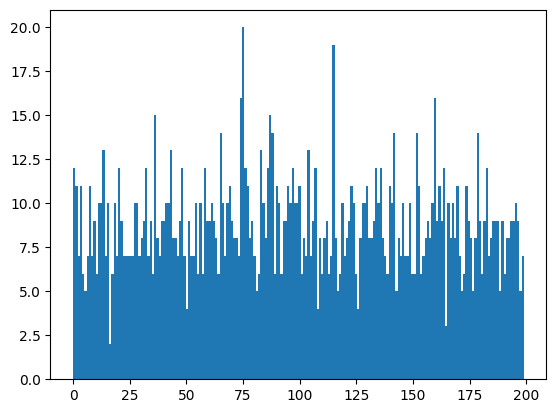

In [176]:
plt.hist(q_y_total, bins=200)

In [203]:
q_label = q_preds_total[low_density_idx[0]]
q_label_samples = torch.where(q_y_total == q_label)[0].tolist()
for i in q_label_samples:
    print(f'{i}-th:       {q_density[i]}')

376-th:       85494
393-th:       0
423-th:       99396
491-th:       89043
560-th:       89768
869-th:       91990
969-th:       91740
1031-th:       92823
1606-th:       98114
1676-th:       95891


label: 66, predictions: 66, 34


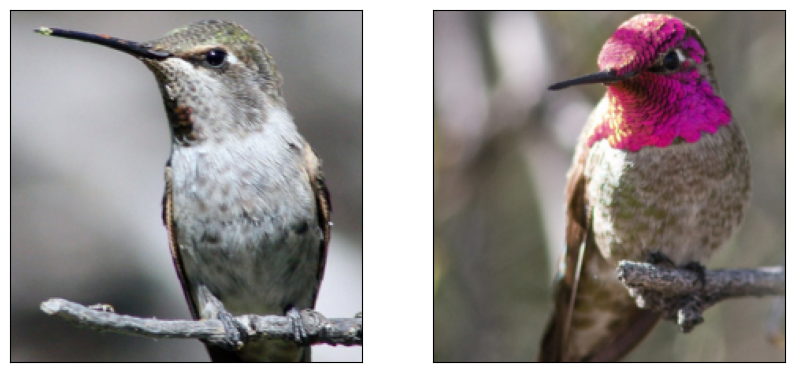

In [205]:
show_smaller([unorm(q_x_total[393]), unorm(q_x_total[1606])]) #315 -> config 기준으로는 dense region
print(f'label: {q_label}, predictions: {q_preds_total[1606]}, {q_preds_total[423]}')

In [179]:
q_label = 9
q_label_samples = torch.where(q_y_total == q_label)[0].tolist()
for i in q_label_samples:
    print(f'{i}-th:       {q_density[i]}')

203-th:       72591
250-th:       94593
733-th:       97641
892-th:       96491
1003-th:       57598
1225-th:       95966
1465-th:       91424
1746-th:       92201
1765-th:       94226


label: 9, predictions: 9, 9


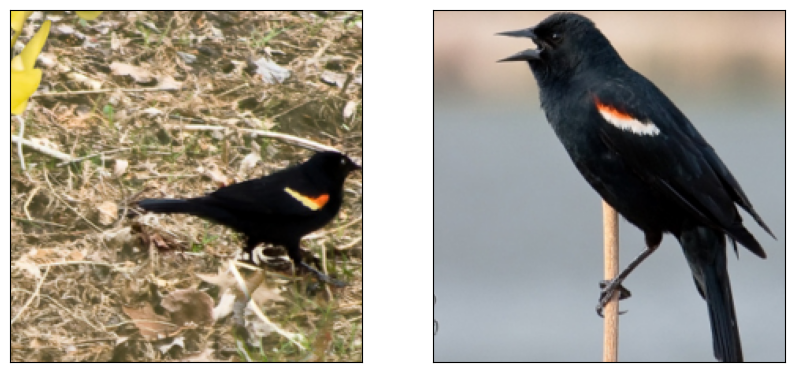

In [180]:
show_smaller([unorm(q_x_total[203]), unorm(q_x_total[1746])])
print(f'label: {q_label}, predictions: {q_preds_total[203]}, {q_preds_total[1746]}')

In [181]:
q_label = 152
q_label_samples = torch.where(q_y_total == q_label)[0].tolist()
for i in q_label_samples:
    print(f'{i}-th:       {q_density[i]}')

75-th:       89156
326-th:       96439
597-th:       94980
928-th:       96468
937-th:       81561
1015-th:       87361
1075-th:       92703
1215-th:       95995
1320-th:       80882
1351-th:       65042
1457-th:       93328
1476-th:       0
1520-th:       98615
1688-th:       85255


label: 152, predictions: 154, 152


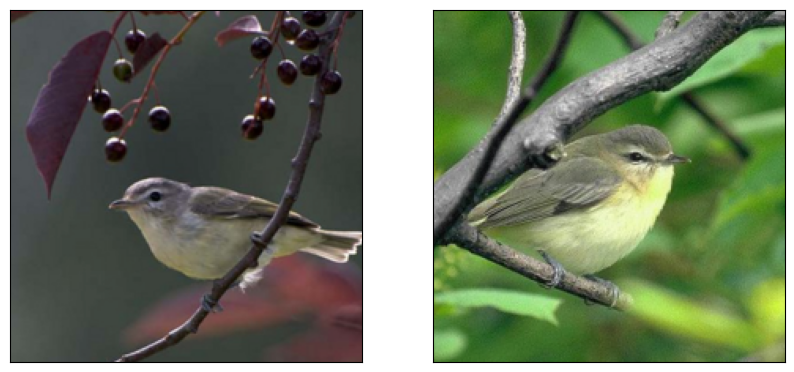

In [182]:
show_smaller([unorm(q_x_total[326]), unorm(q_x_total[75])])
print(f'label: {q_label}, predictions: {q_preds_total[326]}, {q_preds_total[75]}')

In [183]:
q_label = 194
q_label_samples = torch.where(q_y_total == q_label)[0].tolist()
for i in q_label_samples:
    print(f'{i}-th:       {q_density[i]}')

596-th:       96295
609-th:       77465
610-th:       92016
943-th:       92074
1092-th:       89757
1193-th:       92785
1323-th:       91741
1482-th:       89135
1707-th:       97507


label: 194, predictions: 194, 194, 194, 194


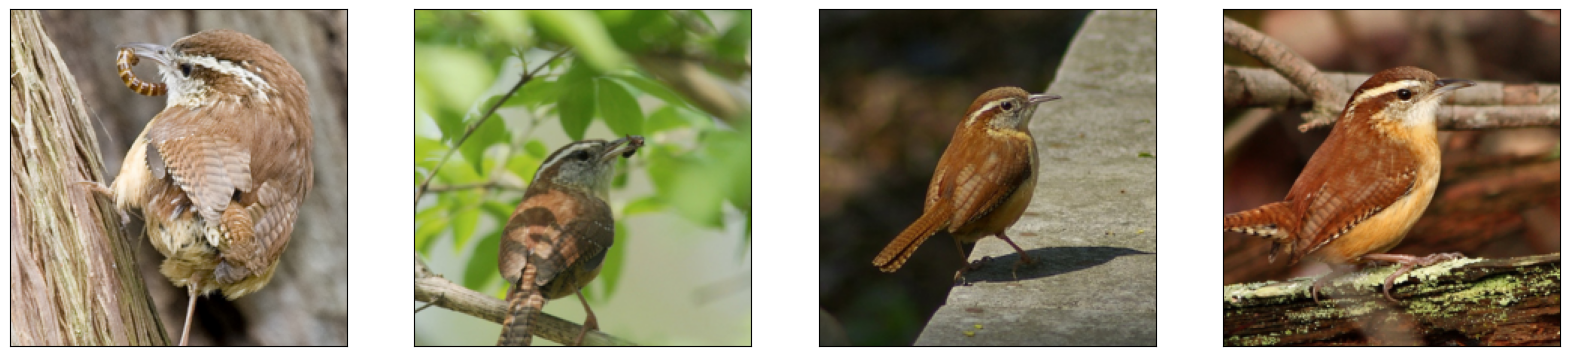

In [184]:
show_smaller([unorm(q_x_total[596]), unorm(q_x_total[1482]), unorm(q_x_total[1092]), unorm(q_x_total[1323])]) # 948: wrong prediction
print(f'label: {q_label}, predictions: {q_preds_total[596]}, {q_preds_total[1482]}, {q_preds_total[1092]}, {q_preds_total[1323]}')

## 같은 prediction을 갖지만 region의 density 정도가 다른 경우 비교

(array([11.,  8.,  8.,  9.,  5.,  2.,  9., 11.,  8.,  8.,  8.,  9., 12.,
        14.,  7.,  9.,  3.,  6.,  9.,  9., 10., 18.,  5., 10.,  5.,  9.,
         8., 18.,  7., 18., 15.,  8., 15.,  7., 11.,  6.,  9.,  9.,  6.,
         7.,  6., 11.,  6., 11.,  8.,  6.,  8.,  8.,  6.,  8.,  4.,  7.,
         6.,  8., 11.,  6., 11.,  5., 11.,  4., 10.,  6., 10.,  8.,  9.,
        20., 11.,  8.,  9., 11.,  9., 14.,  7.,  7., 18., 21., 10.,  8.,
         8.,  8.,  6.,  2.,  6., 12., 10.,  8., 12., 13., 13.,  6., 14.,
        10.,  7., 10.,  7., 13., 13., 15.,  8., 13.,  8., 11., 13.,  8.,
         3.,  6., 10.,  8.,  5.,  8.,  4., 10.,  8.,  7.,  6., 10.,  7.,
         9.,  8., 10.,  9.,  8.,  9., 12., 13.,  5.,  7.,  6.,  6., 14.,
         9.,  9.,  6.,  7., 10., 12.,  9.,  7.,  7.,  6.,  4., 11., 12.,
        10., 13.,  8.,  7.,  5., 11., 13.,  7.,  6., 11.,  6., 11., 11.,
        10.,  7.,  8., 11., 16.,  9., 12.,  7.,  9.,  2.,  2., 11.,  6.,
         7.,  8., 10.,  5.,  6., 11.,  8.,  9.,  3.

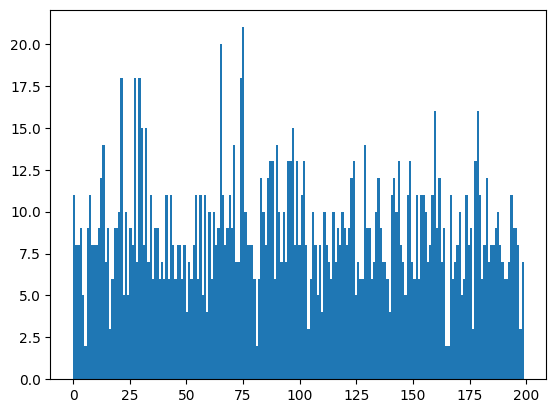

In [185]:
plt.hist(q_preds_total.cpu().detach(), bins=200)

In [208]:
q_pred = q_preds_total[low_density_idx[1]]
q_pred_samples = torch.where(q_preds_total == q_pred)[0].tolist()
for i in q_pred_samples:
    print(f'{i}-th:       {q_density[i]}')

42-th:       95150
49-th:       94499
367-th:       91823
780-th:       87349
810-th:       0
1164-th:       92174
1478-th:       89141
1543-th:       80261
1657-th:       86161


label: 176, 176, predictions: 176


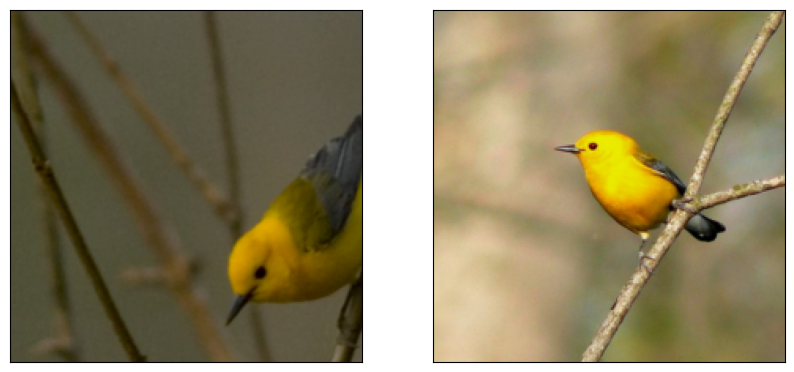

In [209]:
show_smaller([unorm(q_x_total[810]), unorm(q_x_total[42])])
print(f'label: {q_y_total[810]}, {q_y_total[42]}, predictions: {q_pred}')

In [219]:
q_pred = q_preds_total[low_density_idx[5]]
q_pred_samples = torch.where(q_preds_total == q_pred)[0].tolist()
for i in q_pred_samples:
    print(f'{i}-th:       {q_density[i]}')

206-th:       88283
296-th:       38518
487-th:       95770
659-th:       97214
684-th:       89135
1372-th:       0
1432-th:       93853


label: 150, 153, predictions: 150


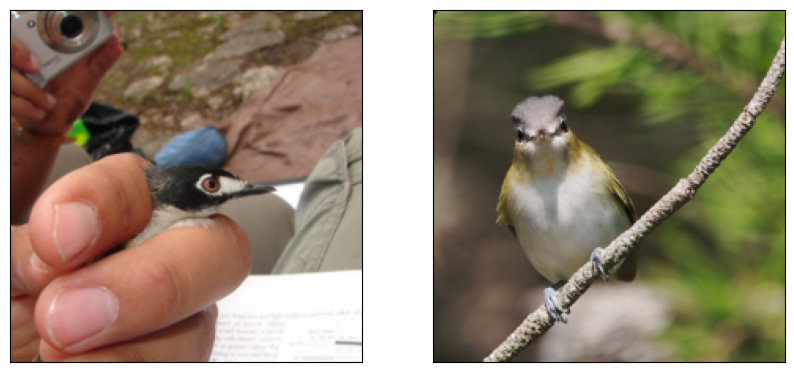

In [220]:
show_smaller([unorm(q_x_total[1372]), unorm(q_x_total[659])])
print(f'label: {q_y_total[1372]}, {q_y_total[659]}, predictions: {q_pred}')

## Region 관찰 (query 이미지를 중심으로)

### High-density region

In [35]:
high_density_idx[:5]

[873, 331, 113, 814, 1660]

In [47]:
h_idx

439

label: [25, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 106, 28, 29, 28, 28]
preds: [28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 106, 28, 29, 28, 28]


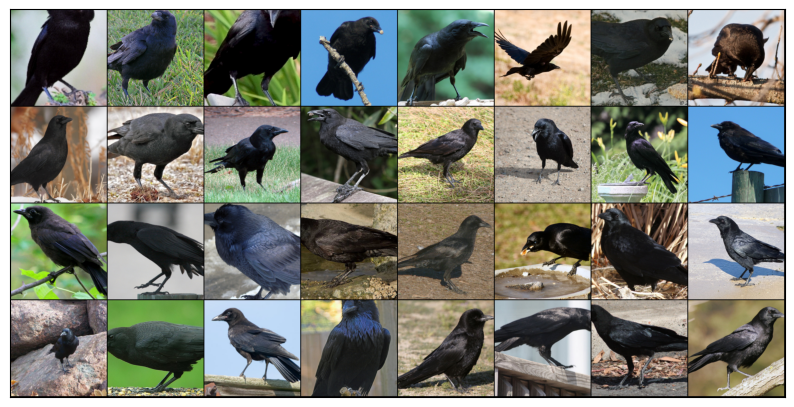

In [46]:
h_idx = high_density_idx[12]
local_nearest_idx, local_nearest_dist = get_local_nearest_euc_and_idx(q_h_total[h_idx], h_total, th=args.q_th)
k = 31#len(local_nearest_idx)
sorted_idx = np.argsort(local_nearest_dist) # 인덱스의 인덱스 / 쿼리와 가까운 순서대로
img_list = [unorm(q_x_total[h_idx])]
label_list = [q_y_total[h_idx].item()]
preds_list = [q_preds_total[h_idx].item()]
for i in range(k):
    img_list.append(unorm(x_total[local_nearest_idx[sorted_idx[i]]]))
    label_list.append(y_total[local_nearest_idx[sorted_idx[i]]].item())
    preds_list.append(preds_total[local_nearest_idx[sorted_idx[i]]].item())
grid = make_grid(img_list)
show(grid)
print(f'label: {label_list}')
print(f'preds: {preds_list}')

label: [104, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 104, 21, 21, 21, 21, 21, 21, 21, 21, 21, 104, 104, 104, 104]
preds: [21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 104, 21, 21, 21, 21, 21, 21, 21, 21, 21, 104, 104, 104, 104]


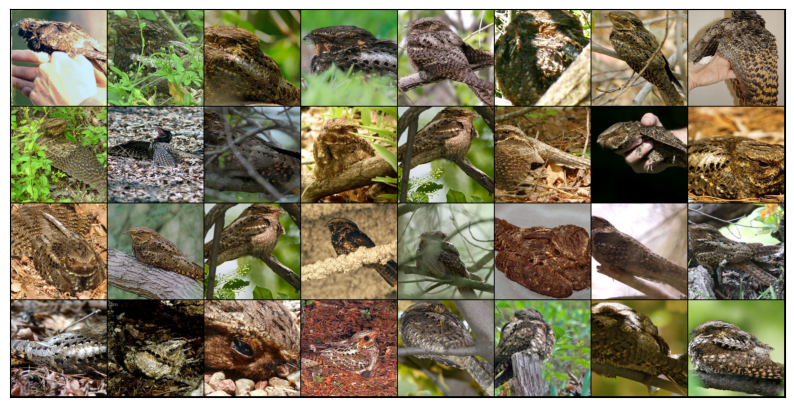

In [229]:
h_idx = high_density_idx[1]
local_nearest_idx, local_nearest_dist = get_local_nearest_euc_and_idx(q_h_total[h_idx], h_total, th=args.q_th)
k = 31 #len(local_nearest_idx)
sorted_idx = np.argsort(local_nearest_dist) # 인덱스의 인덱스 / 쿼리와 가까운 순서대로
img_list = [unorm(q_x_total[h_idx])]
label_list = [q_y_total[h_idx].item()]
preds_list = [q_preds_total[h_idx].item()]
for i in range(k):
    img_list.append(unorm(x_total[local_nearest_idx[sorted_idx[i]]]))
    label_list.append(y_total[local_nearest_idx[sorted_idx[i]]].item())
    preds_list.append(preds_total[local_nearest_idx[sorted_idx[i]]].item())
grid = make_grid(img_list)
show(grid)
print(f'label: {label_list}')
print(f'preds: {preds_list}')

label: [71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71]
preds: [71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71]


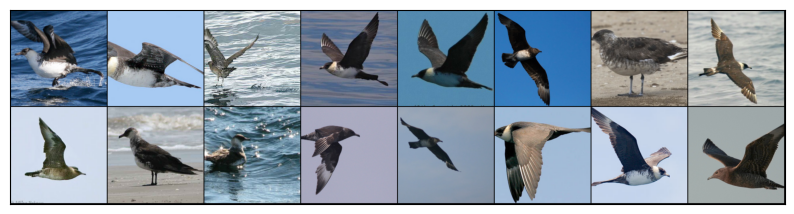

In [34]:
h_idx = high_density_idx[4]
local_nearest_idx, local_nearest_dist = get_local_nearest_euc_and_idx(q_h_total[h_idx], h_total, th=args.q_th)
k = 15 #len(local_nearest_idx)
sorted_idx = np.argsort(local_nearest_dist) # 인덱스의 인덱스 / 쿼리와 가까운 순서대로
img_list = [unorm(q_x_total[h_idx])]
label_list = [q_y_total[h_idx].item()]
preds_list = [q_preds_total[h_idx].item()]
for i in range(k):
    img_list.append(unorm(x_total[local_nearest_idx[sorted_idx[i]]]))
    label_list.append(y_total[local_nearest_idx[sorted_idx[i]]].item())
    preds_list.append(preds_total[local_nearest_idx[sorted_idx[i]]].item())
grid = make_grid(img_list)
show(grid)
print(f'label: {label_list}')
print(f'preds: {preds_list}')

### Low-density region

In [231]:
low_density_idx[:3]

[393, 810, 1439]

In [232]:
q_density[393]

0

### Mid-density region

In [31]:
mid_density_idx = np.where((30000<np.array(q_density)) & (np.array(q_density)<45000))[0]
mid_density_idx

array([   9,   45,   64,  101,  175,  212,  264,  296,  304,  309,  310,
        400,  417,  505,  626,  642,  643,  702,  725,  785,  800,  865,
        980, 1022, 1232, 1240, 1337, 1398, 1467, 1539, 1617])

label: [129, 164]
preds: [164, 164]


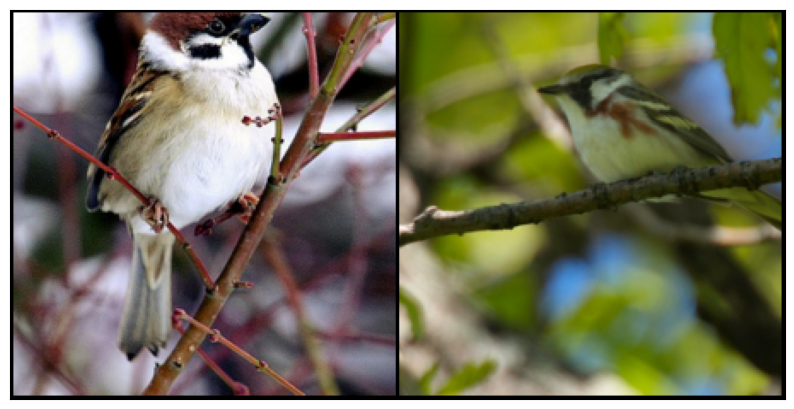

In [24]:
m_idx = mid_density_idx[0] # 시각화해보면 좋을듯!
local_nearest_idx, local_nearest_dist = get_local_nearest_euc_and_idx(q_h_total[m_idx], h_total, th=args.q_th)
k=len(local_nearest_idx)
sorted_idx = np.argsort(local_nearest_dist) # 인덱스의 인덱스 / 쿼리와 가까운 순서대로
img_list = [unorm(q_x_total[m_idx])]
label_list = [q_y_total[m_idx].item()]
preds_list = [q_preds_total[m_idx].item()]
for i in range(k):
    img_list.append(unorm(x_total[local_nearest_idx[sorted_idx[i]]]))
    label_list.append(y_total[local_nearest_idx[sorted_idx[i]]].item())
    preds_list.append(preds_total[local_nearest_idx[sorted_idx[i]]].item())
grid = make_grid(img_list)
show(grid)
print(f'label: {label_list}')
print(f'preds: {preds_list}')

label: [132, 129, 129]
preds: [129, 129, 129]


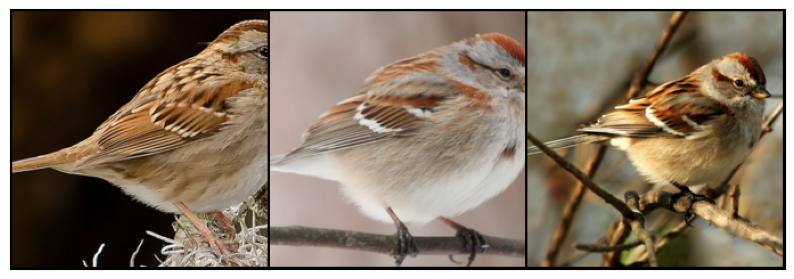

In [25]:
m_idx = mid_density_idx[1]
local_nearest_idx, local_nearest_dist = get_local_nearest_euc_and_idx(q_h_total[m_idx], h_total, th=args.q_th)
k = len(local_nearest_idx)
sorted_idx = np.argsort(local_nearest_dist) # 인덱스의 인덱스 / 쿼리와 가까운 순서대로
img_list = [unorm(q_x_total[m_idx])]
label_list = [q_y_total[m_idx].item()]
preds_list = [q_preds_total[m_idx].item()]
for i in range(k):
    img_list.append(unorm(x_total[local_nearest_idx[sorted_idx[i]]]))
    label_list.append(y_total[local_nearest_idx[sorted_idx[i]]].item())
    preds_list.append(preds_total[local_nearest_idx[sorted_idx[i]]].item())
grid = make_grid(img_list)
show(grid)
print(f'label: {label_list}')
print(f'preds: {preds_list}')

label: [197, 120]
preds: [120, 120]


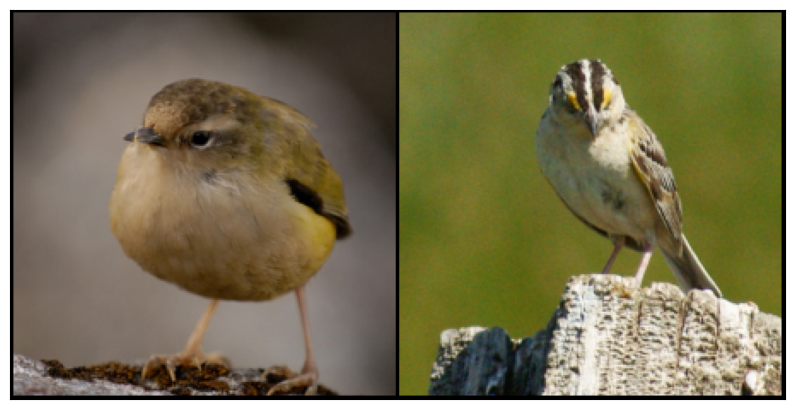

In [33]:
m_idx =  mid_density_idx[1] #2
local_nearest_idx, local_nearest_dist = get_local_nearest_euc_and_idx(q_h_total[m_idx], h_total, th=args.q_th)
k = len(local_nearest_idx)
sorted_idx = np.argsort(local_nearest_dist) # 인덱스의 인덱스 / 쿼리와 가까운 순서대로
img_list = [unorm(q_x_total[m_idx])]
label_list = [q_y_total[m_idx].item()]
preds_list = [q_preds_total[m_idx].item()]
for i in range(k):
    img_list.append(unorm(x_total[local_nearest_idx[sorted_idx[i]]]))
    label_list.append(y_total[local_nearest_idx[sorted_idx[i]]].item())
    preds_list.append(preds_total[local_nearest_idx[sorted_idx[i]]].item())
grid = make_grid(img_list)
show(grid)
print(f'label: {label_list}')
print(f'preds: {preds_list}')

# Misclassified sample

(array([ 17.,   0.,   1.,  12.,   6.,  12.,  21.,  31.,  67., 277.]),
 array([     0. ,  10035.1,  20070.2,  30105.3,  40140.4,  50175.5,
         60210.6,  70245.7,  80280.8,  90315.9, 100351. ]),
 <BarContainer object of 10 artists>)

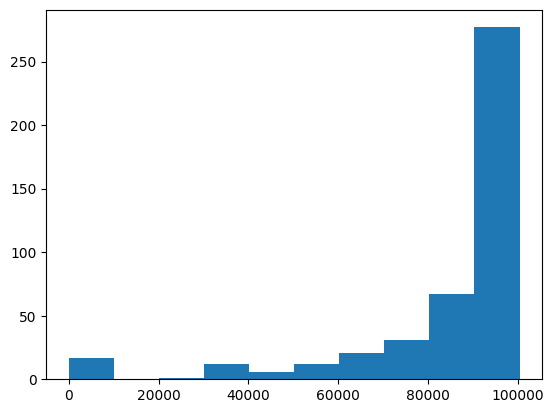

In [238]:
plt.hist(np.array(q_density)[torch.where(q_eq_total == 0)])